<a href="https://colab.research.google.com/github/wajihh/-datasciencecoursera/blob/master/Australia_Weather_Prediction_With_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Austrlian Weather Prediction
If one selects one parameter, such as maximum temperature, and wants to use this single parameter for prediction (e.g., predicting future temperatures based on past temperatures), the approach would differ depending on the specific machine learning task.

Here are two common scenarios:

Predicting Future Values from Past Values (Time Series Forecasting):

In this case, you treat the temperature data as a time series and use previous temperature values to predict future values.
Binary/Regression Classification Based on Single Feature:

If you have additional categorical or continuous target variable data and you want to use the single temperature parameter to predict this target.
## Example for Time Series Forecasting
Let's assume you want to predict the next day's temperature based on the past temperatures. Here is an example code using a simple recurrent neural network (RNN) with LSTM layers in Keras for time series forecasting.

Explanation:
Loading the Dataset:

Load the dataset from a CSV file.
Assume max_temperature is the column name containing temperature data.
Normalizing the Data:

Use MinMaxScaler to normalize the temperature data.
Creating Sequences:

The function create_sequences is used to create sequences of past temperatures to predict the next temperature.
sequence_length determines how many past days to consider.
Splitting the Data:

Split the sequences into training and testing sets.
Building the RNN Model:

Use an LSTM layer to capture the temporal dependencies in the data.
Add a dense output layer to predict the next temperature.
Training and Evaluating the Model:

Train the model using the training data.
Evaluate the model using the test data.
Make predictions and inverse transform them to get the actual temperature values.
Summary:
Time Series Forecasting: This approach is suitable for predicting future values from past values in a sequential dataset.
Single Parameter Prediction: If the dataset has only one parameter, time series forecasting can effectively use past data to predict future values.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
# Load the datasets from google drive earlier downlaoded from Kaggle
data_train = pd.read_csv('/content/drive/MyDrive/Data/weather_training_data.csv')
data_test = pd.read_csv('/content/drive/MyDrive/Data/weather_test_data.csv')
# Concatenate the two sets to get complete dataset
data = pd.concat([data_train, data_test], ignore_index=True)
data.head()


,row ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Row0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0
1,Row1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0
2,Row2,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.0
3,Row3,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,...,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,0.0
4,Row4,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,...,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,0.0


In [ ]:

# Convert the 'MaxTemp' column to a NumPy array and reshape it to 2D
temperatures = data['MaxTemp'].values.reshape(-1, 1)

# Check for NaN values in the dataset and fill them if necessary
def fill_nan_with_average(data):
    for i in range(len(data)):
        if np.isnan(data[i]):
            prev_val = next((data[j] for j in range(i - 1, -1, -1) if not np.isnan(data[j])), np.nan)
            next_val = next((data[j] for j in range(i + 1, len(data)) if not np.isnan(data[j])), np.nan)
            if np.isnan(prev_val) and np.isnan(next_val):
                continue
            elif np.isnan(prev_val):
                data[i] = next_val
            elif np.isnan(next_val):
                data[i] = prev_val
            else:
                data[i] = (prev_val + next_val) / 2
    return data

if np.isnan(temperatures).any():
    print("Data contains NaN values. Filling NaN values with the average of preceding and succeeding values.")
    temperatures = fill_nan_with_average(temperatures)

# Print all values in the temperature column
# Converting to a list for better readability if needed
temperature_list = temperatures.flatten().tolist()

# Print the entire list (be cautious, it will be very long)
# print(temperature_list)

# For practical purposes, let's print the first and last 10 values
print("First 10 temperatures:", temperature_list[:10])
print("Last 10 temperatures:", temperature_list[-10:])


Data contains NaN values. Filling NaN values with the average of preceding and succeeding values.
First 10 temperatures: [22.9, 25.1, 32.3, 29.7, 26.7, 30.1, 30.4, 21.7, 21.0, 27.7]
Last 10 temperatures: [26.3, 27.6, 24.6, 22.2, 19.2, 19.1, 21.4, 22.5, 20.6, 27.0]


In [ ]:

# Normalize the features
scaler = MinMaxScaler()
scaled_temperatures = scaler.fit_transform(temperatures)

# Create sequences for time series forecasting
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 5  # Number of past days to use for predicting the next day
X, y = create_sequences(scaled_temperatures, sequence_length)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the RNN model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Check the training history for NaN values
if np.isnan(history.history['loss']).any() or np.isnan(history.history['val_loss']).any():
    print("NaN values found in the training history. Check data preprocessing and model configuration.")

# Predict using the trained model (example)
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse transform to get actual temperature values

# Optionally, you can inverse transform the y_test values for comparison
y_test_actual = scaler.inverse_transform(y_test)


Epoch 1/10
3555/3555 [==============================] - 42s 10ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 2/10
3555/3555 [==============================] - 36s 10ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 3/10
3555/3555 [==============================] - 36s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 4/10
3555/3555 [==============================] - 35s 10ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 5/10
3555/3555 [==============================] - 34s 9ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 6/10
3555/3555 [==============================] - 34s 9ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 7/10
3555/3555 [==============================] - 35s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 8/10
3555/3555 [==============================] - 33s 9ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 9/10
3555/3555 [==============================] - 35s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 10/10
889/889 [==============================] - 3s 4ms/step 

Model Performance Comments
Based on the reported loss and validation loss after 10 epochs:

Training Loss (loss: 0.0067):
This indicates the mean squared error (MSE) between the predicted maximum temperatures and the actual values on the training dataset. A lower value suggests that the model is fitting the training data well.
Validation Loss (val_loss: 0.0056):
This measures the MSE on the validation dataset. It is a crucial metric as it indicates how well the model generalizes to unseen data. A lower validation loss suggests good generalization.
Interpretation of Results
Model Fit:

Both training loss and validation loss are relatively low and close to each other. This typically indicates that the model is neither overfitting nor underfitting. The model seems to be learning the patterns in the data effectively.
Further Training:

Since the validation loss is still decreasing, the model may benefit from further training. Monitor the validation loss and stop training if it starts to increase, indicating potential overfitting.
Scale of Loss:

The magnitude of the loss values (0.0067 and 0.0056) should be interpreted in the context of the target variable's scale. If the maximum temperature values are scaled (e.g., between 0 and 1), these losses are very small, indicating good performance. If the temperatures are in degrees (e.g., 0 to 40°C), further tuning might be required.
Suggestions for Further Improvements
Hyperparameter Tuning:

Experiment with different architectures (e.g., more layers, different number of units).
Adjust learning rates, batch sizes, and other hyperparameters.
Use grid search or random search techniques for hyperparameter optimization.
Regularization:

Add dropout layers to prevent overfitting, especially if more training epochs are used.
Consider L1 or L2 regularization.
Feature Engineering:

Include additional relevant features (e.g., humidity, wind speed) if available.
Perform feature selection to identify and retain the most important features.
Data Augmentation:

If possible, augment the dataset by generating synthetic data points.
Ensure the dataset is representative of different weather patterns.
Model Evaluation:

Use additional evaluation metrics such as Mean Absolute Error (MAE), R-squared, etc.
Visualize the predictions vs. actual values using plots to gain insights into model performance.
Cross-Validation:

Implement k-fold cross-validation to ensure the model’s robustness and reliability.


Epoch 1/10
3555/3555 [==============================] - 34s 10ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 2/10
3555/3555 [==============================] - 35s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 3/10
3555/3555 [==============================] - 34s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 4/10
3555/3555 [==============================] - 36s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 5/10
3555/3555 [==============================] - 33s 9ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 6/10
3555/3555 [==============================] - 33s 9ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 7/10
3555/3555 [==============================] - 37s 10ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 8/10
3555/3555 [==============================] - 34s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 9/10
3555/3555 [==============================] - 34s 10ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 10/10
889/889 [==============================] - 2s 3ms/step

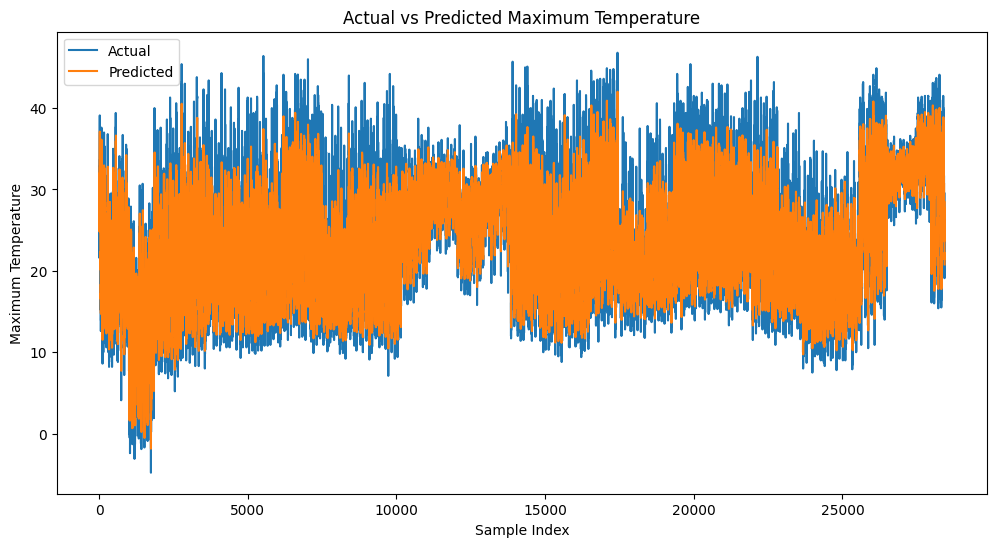

In [ ]:
# Train the model further
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')

# Additional metrics
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Plotting predictions vs. actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Maximum Temperature')
plt.title('Actual vs Predicted Maximum Temperature')
plt.legend()
plt.show()


#Model Performance Comments
Mean Absolute Error (MAE):

An MAE of approximately 2.90 indicates that, on average, the model's predictions are off by around 2.90 degrees in the same unit as the maximum temperature. Depending on the acceptable error margin for your application, this can be considered good or may need improvement.
R-squared (R²):

An R² value of 0.73 suggests that approximately 73% of the variance in the maximum temperature data is explained by the model. This is a decent score, indicating that the model captures a significant portion of the variability in the data. However, there's still room for improvement to capture more variance.
Analysis
Reasonable Performance:

Given an MAE of 2.90 and an R² of 0.73, your model is performing reasonably well but still has some room for improvement. Depending on your specific requirements, this performance might be acceptable or might necessitate further tuning.
Error Analysis:

It's useful to analyze where the model performs well and where it struggles. You might find that the model has higher errors for certain ranges of temperatures, times of the year, or under specific weather conditions.

#Further Improvements
Feature Engineering:

Investigate additional features that might improve model performance, such as humidity, wind speed, time of year, etc.
Model Tuning:

Experiment with different architectures (e.g., deeper networks, different types of layers like GRU or CNN).
Use hyperparameter tuning techniques like grid search or random search.
Regularization:

Add dropout layers or L1/L2 regularization to prevent overfitting.
Cross-Validation:

Use cross-validation to ensure the model's robustness across different subsets of the data.
Ensemble Methods:

Combine predictions from multiple models (e.g., ensemble learning) to improve overall performance.
Temporal Analysis:

Consider more advanced time series techniques if there are temporal patterns in your data that the current model isn't capturing well.
Summary
Your model's performance, with an MAE of 2.90 and an R² of 0.73, is a good starting point. Visualizing the predictions versus actual values provides more insights into the model's behavior. While a confusion matrix is not applicable for regression tasks, focusing on further tuning and enhancement techniques can help improve your model's accuracy and robustness.